# Comparison of different demosaicing algorithms in Rawpy
# **Part I:**<br>
In this part, we would evaluate the effect of using different demosaicing algorithms on images which are designed manually. <br>
In the first part, we design a raw image contains 4 rectangulars. By doing postprocess on this image, we are able to observe the effect of using different demosaicing algorithms by looking at the horizontal and vertical artifacts.<br>
The shape of first test image can be describe as   White (Left-Top), Black(Right-Top), Black(Left-Bottom), White(Right-Bottom).<br>                                                   

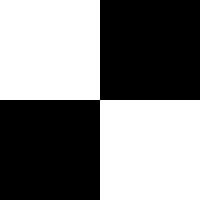 

In [3]:
# First Test :  W   B
#               B   W
import rawpy
import PIL
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rawpy import DemosaicAlgorithm
import time
path = '/home/qingyao/Desktop/Topic 1: Demosaic/Difference Between Algorithms/space.NEF'   
                                                               # image size 3292 x 4940
with rawpy.imread(path) as raw:                 # Open an existing image and rewrite it
    print(raw.raw_type)   # raw_type : flat 
    print(raw.color_desc) # color_desc : RGBG
    raw_image = raw.raw_image_visible
    m,n = raw_image.shape
    print(m,n)
    print(np.max(raw_image))
    print(np.min(raw_image))
    i = int(m/2)
    j = int(n/2)
    
    # Then change the value of raw_image_visible to either 0 or np.max(raw_image)
    raw.raw_image_visible[0:i,0:j] = np.max(raw_image)
    raw.raw_image_visible[0:i,j:n] = 0
    raw.raw_image_visible[i:m,0:j] = 0
    raw.raw_image_visible[i:m,j:n] = np.max(raw_image)
    Time = np.zeros(13)
    # After creating the test image, we start to postprocess the image using 13 kinds of demosaicing algorithms
    for k in range (13):
        start = time.time()
        img = raw.postprocess(demosaic_algorithm = DemosaicAlgorithm(k))
        end = time.time()
        print('Processing Time of Demosaic Algorithm %s is'%DemosaicAlgorithm(k).name,(end - start))
        Time[k] = end - start
        x = img[i-20:i+20,j-20:j+20,:] # Instead of directly looking at the postprocessed image,
                                       # we can select the part where we are interested in.
                                       # Normally we can select the part which contains horizontal or vertical edges.
        zoom = 30   # The coefficient zoom is used to control how big you wanna enlarge the part you are interested.
                    # For example, if zoom = 30, then we create a matrix with size 30x30 and fill those 900 pixels 
                    # with the value of a single pixel which belongs to the selected part.
                    # This step makes the detail of postprocessed image more visible.
        g,h,d = x.shape
        detail = np.zeros((g*zoom,h*zoom,d))
        for a in range (zoom):
            for b in range (zoom):
                detail[a::zoom,b::zoom] = x
        detail = detail.astype(np.uint8)
        imageio.imsave('default %s .tiff' %DemosaicAlgorithm(k).name, img)  # Save the whole postprocessed image
        imageio.imsave('detail %s .tiff' %DemosaicAlgorithm(k).name, detail)# Save the enlarged detals
    Order = np.argsort(Time)
    print('Sort the demosaicing algorithms by processing time:')
    for k in range(13):
        print('Time = %.5f ; '% Time[Order[k]], ' Algorithm : ',DemosaicAlgorithm(Order[k]).name)

RawType.Flat
b'RGBG'
3292 4940
4095
0
Processing Time of Demosaic Algorithm LINEAR is 0.6746931076049805
Processing Time of Demosaic Algorithm VNG is 2.377310037612915
Processing Time of Demosaic Algorithm PPG is 0.5223655700683594
Processing Time of Demosaic Algorithm AHD is 0.754077672958374
Processing Time of Demosaic Algorithm DCB is 1.5515832901000977
Processing Time of Demosaic Algorithm MODIFIED_AHD is 0.7774841785430908
Processing Time of Demosaic Algorithm AFD is 0.7462210655212402
Processing Time of Demosaic Algorithm VCD is 0.7582228183746338
Processing Time of Demosaic Algorithm VCD_MODIFIED_AHD is 0.7887017726898193
Processing Time of Demosaic Algorithm LMMSE is 0.7725353240966797
Processing Time of Demosaic Algorithm AMAZE is 0.7967326641082764
Processing Time of Demosaic Algorithm DHT is 0.8797562122344971
Processing Time of Demosaic Algorithm AAHD is 3.8184080123901367
Sort the demosaicing algorithms by processing time:
Time = 0.52237 ;   Algorithm :  PPG
Time = 0.67469

It can be found that those 13 algorithms can be concluded into 3 types based on the **processing time**:<br>
**(1) PPG** : Always the Fastest<br>
**(2) LINEAR, VCD_MODIFIED_AHD, VCD,MODIFIED_AHD, LMMSE, AMAZE,AFD, DHT,  AHD**: It can be found that no matter what raw input you are using, these 8 algorithms always have close processing time. <br>
**(3) DCB , VNG and AAHD** : These three algorithms are the slowest 3 algorithms no matter how you change the raw input. The processing time of these 3 algorithms could be the double or even treble times longer than other algorithms.<br>

**Comments on the test results :** <br>
**(a) Comments on postprocessed images:** <br>
It can be found that AAHD and DHT cannot correctly produce the desired color. Intead of Black (desired), they interpolate more red pattern. Initially, no median filter is used to reduce the color artifacts. We can find that there are plenty black pixels in interpolated red part. Instead of changing the interpolated red pixels, applying median filter can only eliminate the black pixels from red region. All other 11 algorithms can successfully recover white and black parts. 

**(b) Comments on enlarged details:**<br>
The 13 algorithms can be seperated into several groups based on how good they are on processing the vertical and horizontal edges.<br>
1. **AAHD :** 
Bad result. Wrong recovered color with color artifacts in the cross.<br>
2. **DHT :**
Bad result. Wrong recovered color without color artifacts in cross.<br>
3. **LINEAR :**
Acceptable result. Recover black and white correctly. But there exists severe zipper effects along both horizontal and vertical edges.<br>
4. **DCB :**
Acceptable result. Recover black and white correctly. Contains light zipper effects only on vertical directions.<br>
5. **VNG :** 
Acceptable result. Recover black and white correctly. Instead of zipper effects, it contains false color along horizontal and vertical edges as straight line.<br>
6. **AFD, AHD, AMAZE, LMMSE,MODIFIED_AHD, PPG, VCD, VCD_MODIFIED_AHD :**
Good results. Recover black and white correctly. These 8 algorithms all work well in reducing zipper effect even though they all introduce color artifacts in cross. PPG is a little bit worse than others.<br>    

# **Part II :**<br>
To fully evaluate the behavior of these algorithms, I create a new image which contains more edges including horizontal, vertical and diagonal edges.<br>
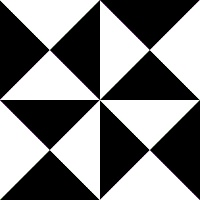

In [2]:
# Second Test (Diagonal)
import rawpy
import PIL
import imageio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from rawpy import DemosaicAlgorithm
import time
path = '/home/qingyao/Desktop/Topic 1: Demosaic/Difference Between Algorithms/1.3FR'   
                                        # Open another image with shape 4096 x 4096
with rawpy.imread(path) as raw:
    print(raw.raw_type)
    print(raw.color_desc)
    x,y = raw.raw_image.shape
    max_pixel = np.max(raw.raw_image)
    min_pixel = np.min(raw.raw_image)
    print(x,y)
    print(max_pixel)
    print(min_pixel)
    raw.raw_image_visible[:,:] = 0  # initialize all black
    
    # Then create the test image which includes vertical, horizontal and diagonal edges
    
    i = int(x/2)
    k = int(i/2)
    for m in range (k):  # rewrite the image
        raw.raw_image_visible[m,m:(i-m)] = max_pixel
        raw.raw_image_visible[m,i:(i+m)] = max_pixel
        raw.raw_image_visible[m,(x-m):x] = max_pixel
    for m in range (k,i):
        raw.raw_image_visible[m,k-(m-k):k+(m-k)] = max_pixel
        raw.raw_image_visible[m,i:(i+k)-(m-k)] = max_pixel
        raw.raw_image_visible[m,(i+k)+m-k:x] = max_pixel
    for m in range (i,i+k):
        raw.raw_image_visible[m,0:m-i] = max_pixel
        raw.raw_image_visible[m,i-(m-i):i] = max_pixel
        raw.raw_image_visible[m,i+m-i:x-(m-i)] = max_pixel
    for m in range (i+k,x):
        raw.raw_image_visible[m,0:k-(m-i-k)] = max_pixel
        raw.raw_image_visible[m,k+m-i-k:i] = max_pixel
        raw.raw_image_visible[m,(i+k)-(m-i-k):(i+k)+(m-i-k)] = max_pixel
    
    # Then start to process raw data with different demosaicing algorithms
    Time = np.zeros(13)

    for k in range (13):
        start = time.time()
        img = raw.postprocess(demosaic_algorithm = DemosaicAlgorithm(k))
        end = time.time()
        print('Processing Time of Demosaic Algorithm %s is'%DemosaicAlgorithm(k).name,(end - start))
        Time[k] = end - start
        zoom = 30
        x = img[i-20:i+20,i-20:i+20,:]
        g,h,d = x.shape
        detail = np.zeros((g*zoom,h*zoom,d))
        for a in range (zoom):
            for b in range (zoom):
                detail[a::zoom,b::zoom] = x
        detail = detail.astype(np.uint8)
        imageio.imsave('img_ %s .tiff' %DemosaicAlgorithm(k).name, img) 
        imageio.imsave('detail %s .tiff' %DemosaicAlgorithm(k).name, detail)
    Order = np.argsort(Time)
    print('Sort the demosaicing algorithms by processing time:')
    for k in range(13):
        print('Time = %.5f ; '% Time[Order[k]], ' Algorithm : ',DemosaicAlgorithm(Order[k]).name)


RawType.Flat
b'RGBG'
4096 4096
65535
0
Processing Time of Demosaic Algorithm LINEAR is 1.091998815536499
Processing Time of Demosaic Algorithm VNG is 2.5273640155792236
Processing Time of Demosaic Algorithm PPG is 0.8797447681427002
Processing Time of Demosaic Algorithm AHD is 1.3889737129211426
Processing Time of Demosaic Algorithm DCB is 2.469360589981079
Processing Time of Demosaic Algorithm MODIFIED_AHD is 1.1608638763427734
Processing Time of Demosaic Algorithm AFD is 1.1252281665802002
Processing Time of Demosaic Algorithm VCD is 1.144036054611206
Processing Time of Demosaic Algorithm VCD_MODIFIED_AHD is 1.155858039855957
Processing Time of Demosaic Algorithm LMMSE is 1.1348621845245361
Processing Time of Demosaic Algorithm AMAZE is 1.2109441757202148
Processing Time of Demosaic Algorithm DHT is 1.2396042346954346
Processing Time of Demosaic Algorithm AAHD is 4.157824277877808
Sort the demosaicing algorithms by processing time:
Time = 0.87974 ;   Algorithm :  PPG
Time = 1.09200 ;

**Comments on the test results :** <br> 
**a. Based on processing time:** It can be found that our conclusion from last test still holds true in this test.<br>
**b. Based on processed result (focus on details) :**<br>
1. **AAHD :**
Bad result. Wrong recovered color with color artifacts in the cross and zipper effect along diagonal directions.<br>
2. **DHT :** 
Bad result. Wrong recovered color with smaller color artifacts in the cross.<br>
3. **LINEAR :**  
Acceptable result. Recover black and white correctly. Strong zipper effect exists in all edges  along all directions (H,V,D). Color artifacts in the cross.<br>
4. **DCB :**
Acceptable result. Recover black and white correctly. Contains light zipper effects only on horizontal direction and strong zipper effects along diagonal direction.<br>
5. **VNG :** 
Acceptable result. Recover black and white correctly. It contains false color along horizontal and vertical edges as straight line and strong zipper effects along diagonal direction.<br>
6. **AFD, AHD, VCD, VCD_MODIFIED_AHD, PPG, AMAZE, LMMSE, MODIFIED_AHD:** 
Good results. Recover black and white correctly. All 8 algorithms have zipper effects along diagonal direction and false color in the cross. PPG has smaller zipper effects but bigger color artifacts compared to other 7 algorithms.

# Problem Analysis:
A lot of demosaicing algorithms are based on the assumption that color pattern in natural image would not have a sudden change. Thus when we analyze these algorithms using manually created images with sharp edges and sudden change of colors, the assumption of some algorithms would be violated. That is why their results show us a wrong color interpolation. <br>
But when we test them using natural images, all algorithms show a good performance on handling color change. The performance difference between using different algorithms is not that clear compared to the results we had above. But we can always find that LINEAR algorithm will severely blur the existing edges than any other algorithms even though LINEAR only requires a relatively short processing time.   

# Algorithms Analysis
**Basic Assumption:** consistent color ratio (no gamma correction) and consistent color difference (gamma corrected, assume color difference signal is low pass signal)
            
1. **Linear :** <br>
Fast, take advantage of both spatial and spectral correlation to do linear combination; Blur, not enough details

2. **VNG (variable number of gradients) :**  <br>
Slow, take advantage of spatial correlation. VNG computes gradient on 8 directions and choose the direction with smallest gradient.VNG is quite computationally intensive and is not remotely suitable for real-time debayering of video images, but is very accurate as can be seen in Figures 3e and 4e. While the image is not a perfect recreation, few would argue that it is one half or one quarter as good as the original. In fact, if you use a tool like PhotoShop to layer the original and the VNG reconstruction and show the difference,
it takes a good bit of stretching to see any difference show through. <br>
Ref : https://thedailynathan.com/demosaic/algorithms.php?algorithm=variablenumbergradients&image=raw.png

3. **PPG (Patterned Pixel Grouping):**  <br>
Fast, take advantage of spatial and spectral correlation, compute Green first, compare gradients on 4 directions; then Red and Blue at Green pixels; then Red (Blue) at Blue (Red) pixels.<br>
Ref : https://sites.google.com/site/chklin/demosaic/

4. **AHD (Adaptive homogeneity-directed) : Default**  <br>
interpolating in the direction with fewer color artifacts. Need iteration steps to reduce interpolation artifact (by median filter).<br>
Ref : http://nagykrisztian.com/store/hirakawa.pdf

5. **DCB :**  <br>
similar results to AMaZE , better at avoiding false colors especially in images from cameras without anti-aliasing filters

6. **Modified-AHD**

7. **AFD (Adaptive Frequency Domain) :**  <br>
recover the luma component from the CFA signal using a lowpass filter and the two chrominance components using appropriate bandpass filters.
                                    f(R)     1   -1   -2     f(L)
                                    f(G)  =  1    1    0  *  f(C1)
                                    f(B)     1   -1    2     f(C2)
Adaptive:  giving more weight to that component assumed to suffer less from crosstalk

8. **VCD (Variance of color-difference) :**  <br>
Missing green samples are first estimated based on the variances of the color differences along different edge directions. The missing red and blue components are then estimated based on the interpolated green plane. Compute different parameters than Linear. Use new parameters to determine main edge direction. Interpolation function is as same as Linear. More fine texture pattern details can be preserved.

9. **VCD_MODIFIED_AHD** 

10. **LMMSE (Linear Minimum Mean Square-Error Estimation):** <br>
Use other techniques to estimate R,G,B first.  directional demosaicking noises = actual(G-R) - estimated(G-R)
demosaicking noises are zero-mean random process                             v = x - y(known)
Key idea: Use LMMSE method to estimate true color difference (x) from known y.
mean of x is estimated by passing y through a low pass (Gaussian) filter.
var of x is esimated using computed mean of x and the known result of y after the low pass filter.
var of v is computed using above two results.
Optimal fusion weights (vertical and horizontal) are computed using var of x in vertical and horizontal directions
Then get robust x (actual color difference). Compute G on R/B pixels. Get robust G. Compute R,B using simple avg.<br>
Ref: https://www4.comp.polyu.edu.hk/~cslzhang/paper/LMMSEdemosaicing.pdf

11. **AMAZE (Aliasing Minimization and Zipper Elimination)** 

12. **DHT**

13. **AAHD**
